In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle, class_weight
from sklearn.metrics import (
    classification_report, confusion_matrix,
    average_precision_score, precision_recall_curve, f1_score
)

# Imports pour le multiprocessing
import multiprocessing
from tqdm import tqdm

# --- NOTRE NOUVEL IMPORT ---
from src.periodogram import generate_periodogram

# Métrique Keras
pr_auc = tf.keras.metrics.AUC(curve='PR', name='pr_auc')

print("Bibliothèques importées.")

Bibliothèques importées.


In [2]:
print("Chargement et mélange des données brutes...")
train_df = pd.read_csv('../data/raw/train.csv')

X_raw = train_df.drop('LABEL', axis=1).values
y = train_df['LABEL'].values - 1  # (0, 1)

X_raw_shuffled, y_shuffled = shuffle(X_raw, y, random_state=42)

print(f"Forme de X_raw_shuffled : {X_raw_shuffled.shape}")
print(f"Forme de y_shuffled : {y_shuffled.shape}")

Chargement et mélange des données brutes...
Forme de X_raw_shuffled : (5087, 3197)
Forme de y_shuffled : (5087,)


In [3]:
# Cellule 3 : Pré-traitement (Génération des Périodogrammes)
# -----------------------------------------------------------------

N_BINS = 1000 # C'est notre nouvelle dimension : 1000 points de fréquence

X_data_to_process = X_raw_shuffled
y_data_to_process = y_shuffled

print(f"Démarrage de la génération des périodogrammes (vers {N_BINS} bins)...")

N_CORES = multiprocessing.cpu_count() - 1
if N_CORES < 1: N_CORES = 1
print(f"Utilisation de {N_CORES} cœurs CPU...")

# Préparer les arguments (row, n_bins)
func_args = [(row, N_BINS) for row in X_data_to_process]

with multiprocessing.Pool(processes=N_CORES) as pool:
    # On utilise starmap car notre fonction a 2 arguments
    X_periodogram = list(tqdm(pool.starmap(generate_periodogram, func_args), total=len(X_data_to_process)))

# Convertir en array numpy
X_periodogram = np.array(X_periodogram)
y = y_data_to_process

print("Génération des périodogrammes terminée !")
print(f"Forme de X_periodogram (nos nouvelles features) : {X_periodogram.shape}")

Démarrage de la génération des périodogrammes (vers 1000 bins)...
Utilisation de 7 cœurs CPU...


100%|██████████| 5087/5087 [00:00<00:00, 2445715.78it/s]

Génération des périodogrammes terminée !
Forme de X_periodogram (nos nouvelles features) : (5087, 1000)


In [4]:
print("Division des données (Train/Test)...")
X_train, X_test, y_train, y_test = train_test_split(
    X_periodogram, # <-- Nos nouvelles données
    y,             # <-- Nos labels
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Redimensionner pour le CNN
X_train_cnn = np.expand_dims(X_train, axis=-1)
X_test_cnn = np.expand_dims(X_test, axis=-1)

# Notre nouvelle forme d'entrée
INPUT_SHAPE = (N_BINS, 1) # (1000, 1)

print(f"Forme X_train_cnn : {X_train_cnn.shape}")
print(f"Forme X_test_cnn : {X_test_cnn.shape}")

Division des données (Train/Test)...
Forme X_train_cnn : (4069, 1000, 1)
Forme X_test_cnn : (1018, 1000, 1)


In [5]:
# Cellule 5 : Construction du Modèle (v17)

def build_periodogram_model(input_shape):
    model = tf.keras.models.Sequential(name="CNN_v17_Periodogram")

    model.add(tf.keras.layers.Input(shape=input_shape))

    model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=7, activation='relu', padding='same'))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=3))
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu', padding='same'))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=3))
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=3))
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    return model

model = build_periodogram_model(INPUT_SHAPE)

# On compile avec notre LR stable (1e-4)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', pr_auc]
)

model.summary()

Model: "CNN_v17_Periodogram"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1000, 32)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 333, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 333, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 333, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 111, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 111, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 111, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 37, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 37, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4736)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       303,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 338,497 (1.29 MB)

 Trainable params: 338,497 (1.29 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Cellule 5b : Calculer les Poids de Classe
# ----------------------------------------
weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = {0: weights[0], 1: weights[1]}

print(f"Poids de classe (0: 'Pas Planète'): {weights[0]:.2f}")
print(f"Poids de classe (1: 'Planète'):   {weights[1]:.2f}")

Poids de classe (0: 'Pas Planète'): 0.50
Poids de classe (1: 'Planète'):   67.82


In [7]:
# Cellule 6 : Callbacks et Entraînement (v17)

LOG_DIR = './logs/v17_periodogram'
MODEL_PATH = '../models/cnn_v17_periodogram_best.h5'

!rmdir /S /Q .\\logs\\v17_periodogram

tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=LOG_DIR, histogram_freq=1)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=MODEL_PATH, save_best_only=True,
    monitor='val_pr_auc', mode='max', verbose=1
)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_pr_auc', mode='max', patience=10,
    restore_best_weights=True, verbose=1
)

print(f"Début de l'entraînement (v17 - Périodogramme)...")
history = model.fit(
    X_train_cnn,
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_cnn, y_test),
    callbacks=[tensorboard_cb, checkpoint_cb, early_stopping_cb],
    class_weight=class_weights_dict # On utilise les poids !
)

Le fichier sp‚cifi‚ est introuvable.


Début de l'entraînement (v17 - Périodogramme)...
Epoch 1/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9371 - loss: 1.6266 - pr_auc: 0.0055
Epoch 1: val_pr_auc improved from None to 0.01457, saving model to ../models/cnn_v17_periodogram_best.h5


128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.8973 - loss: 1.2239 - pr_auc: 0.0059 - val_accuracy: 0.8193 - val_loss: 0.6504 - val_pr_auc: 0.0146
Epoch 2/100
125/128 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7813 - loss: 0.6734 - pr_auc: 0.0089
Epoch 2: val_pr_auc did not improve from 0.01457
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7363 - loss: 0.6838 - pr_auc: 0.0101 - val_accuracy: 0.4784 - val_loss: 0.6824 - val_pr_auc: 0.0143
Epoch 3/100
125/128 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6819 - loss: 0.7938 - pr_auc: 0.0141
Epoch 3: val_pr_auc improved from 0.01457 to 0.01526, saving model to ../models/cnn_v17_periodogram_best.h5


128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6874 - loss: 0.6803 - pr_auc: 0.0101 - val_accuracy: 0.6100 - val_loss: 0.6424 - val_pr_auc: 0.0153
Epoch 4/100
125/128 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7404 - loss: 0.6935 - pr_auc: 0.0122
Epoch 4: val_pr_auc improved from 0.01526 to 0.01538, saving model to ../models/cnn_v17_periodogram_best.h5


128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7063 - loss: 0.6651 - pr_auc: 0.0109 - val_accuracy: 0.4784 - val_loss: 0.6629 - val_pr_auc: 0.0154
Epoch 5/100
125/128 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6769 - loss: 0.6132 - pr_auc: 0.0180
Epoch 5: val_pr_auc improved from 0.01538 to 0.01573, saving model to ../models/cnn_v17_periodogram_best.h5


128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6783 - loss: 0.6780 - pr_auc: 0.0151 - val_accuracy: 0.4077 - val_loss: 0.6881 - val_pr_auc: 0.0157
Epoch 6/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6799 - loss: 0.5768 - pr_auc: 0.0576
Epoch 6: val_pr_auc did not improve from 0.01573
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6537 - loss: 0.6350 - pr_auc: 0.0178 - val_accuracy: 0.4283 - val_loss: 0.6770 - val_pr_auc: 0.0152
Epoch 7/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6821 - loss: 0.5892 - pr_auc: 0.0354
Epoch 7: val_pr_auc did not improve from 0.01573
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6852 - loss: 0.6262 - pr_auc: 0.0157 - val_accuracy: 0.4273 - val_loss: 0.6652 - val_pr_auc: 0.0142
Epoch 8/100
125/128 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5969 - loss: 0.6928 - pr_auc: 0.0350
Epoch 8: val_pr_auc did not improve from 0.01573
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6188 - loss: 0

128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6606 - loss: 0.6110 - pr_auc: 0.0160 - val_accuracy: 0.5373 - val_loss: 0.6243 - val_pr_auc: 0.0163
Epoch 11/100
126/128 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7522 - loss: 0.5246 - pr_auc: 0.0193
Epoch 11: val_pr_auc improved from 0.01626 to 0.01683, saving model to ../models/cnn_v17_periodogram_best.h5


128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7321 - loss: 0.6122 - pr_auc: 0.0147 - val_accuracy: 0.4086 - val_loss: 0.6741 - val_pr_auc: 0.0168
Epoch 12/100
125/128 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5877 - loss: 0.6176 - pr_auc: 0.0080
Epoch 12: val_pr_auc did not improve from 0.01683
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6314 - loss: 0.6442 - pr_auc: 0.0114 - val_accuracy: 0.4028 - val_loss: 0.6659 - val_pr_auc: 0.0167
Epoch 13/100
125/128 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5519 - loss: 0.6224 - pr_auc: 0.0172
Epoch 13: val_pr_auc improved from 0.01683 to 0.01855, saving model to ../models/cnn_v17_periodogram_best.h5


128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5947 - loss: 0.6064 - pr_auc: 0.0132 - val_accuracy: 0.6670 - val_loss: 0.5611 - val_pr_auc: 0.0185
Epoch 14/100
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7473 - loss: 0.5358 - pr_auc: 0.0319
Epoch 14: val_pr_auc did not improve from 0.01855
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6894 - loss: 0.6039 - pr_auc: 0.0160 - val_accuracy: 0.4371 - val_loss: 0.6498 - val_pr_auc: 0.0168
Epoch 15/100
125/128 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5801 - loss: 0.6391 - pr_auc: 0.0131
Epoch 15: val_pr_auc did not improve from 0.01855
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.5891 - loss: 0.6249 - pr_auc: 0.0136 - val_accuracy: 0.5609 - val_loss: 0.5883 - val_pr_auc: 0.0184
Epoch 16/100
126/128 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6875 - loss: 0.5784 - pr_auc: 0.0238
Epoch 16: val_pr_auc improved from 0.01855 to 0.01864, saving model to ../models/cnn_v17_periodogram_best.h5


128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6746 - loss: 0.6029 - pr_auc: 0.0210 - val_accuracy: 0.4470 - val_loss: 0.6635 - val_pr_auc: 0.0186
Epoch 17/100
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6018 - loss: 0.6169 - pr_auc: 0.0196
Epoch 17: val_pr_auc did not improve from 0.01864
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5812 - loss: 0.6217 - pr_auc: 0.0129 - val_accuracy: 0.4597 - val_loss: 0.6314 - val_pr_auc: 0.0178
Epoch 18/100
125/128 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5966 - loss: 0.6291 - pr_auc: 0.0316
Epoch 18: val_pr_auc did not improve from 0.01864
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5952 - loss: 0.5936 - pr_auc: 0.0238 - val_accuracy: 0.5344 - val_loss: 0.6118 - val_pr_auc: 0.0182
Epoch 19/100
126/128 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6752 - loss: 0.5651 - pr_auc: 0.0175
Epoch 19: val_pr_auc improved from 0.01864 to 0.01976, saving model to ../models/cnn_v17_periodogram_best.h5


128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.6498 - loss: 0.5730 - pr_auc: 0.0191 - val_accuracy: 0.5108 - val_loss: 0.6233 - val_pr_auc: 0.0198
Epoch 20/100
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6665 - loss: 0.6708 - pr_auc: 0.0120
Epoch 20: val_pr_auc did not improve from 0.01976
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.6731 - loss: 0.6161 - pr_auc: 0.0131 - val_accuracy: 0.6454 - val_loss: 0.5453 - val_pr_auc: 0.0197
Epoch 21/100
126/128 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7362 - loss: 0.6452 - pr_auc: 0.0403
Epoch 21: val_pr_auc improved from 0.01976 to 0.02109, saving model to ../models/cnn_v17_periodogram_best.h5


128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7257 - loss: 0.6004 - pr_auc: 0.0202 - val_accuracy: 0.5619 - val_loss: 0.5717 - val_pr_auc: 0.0211
Epoch 22/100
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6549 - loss: 0.6029 - pr_auc: 0.0176
Epoch 22: val_pr_auc did not improve from 0.02109
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6299 - loss: 0.6135 - pr_auc: 0.0140 - val_accuracy: 0.5403 - val_loss: 0.6090 - val_pr_auc: 0.0206
Epoch 23/100
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7069 - loss: 0.5934 - pr_auc: 0.0120
Epoch 23: val_pr_auc improved from 0.02109 to 0.02158, saving model to ../models/cnn_v17_periodogram_best.h5


128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7267 - loss: 0.5904 - pr_auc: 0.0146 - val_accuracy: 0.5236 - val_loss: 0.6075 - val_pr_auc: 0.0216
Epoch 24/100
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6421 - loss: 0.5174 - pr_auc: 0.0168
Epoch 24: val_pr_auc improved from 0.02158 to 0.02188, saving model to ../models/cnn_v17_periodogram_best.h5


128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.5923 - loss: 0.6061 - pr_auc: 0.0155 - val_accuracy: 0.4656 - val_loss: 0.6289 - val_pr_auc: 0.0219
Epoch 25/100
126/128 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6902 - loss: 0.4753 - pr_auc: 0.0472
Epoch 25: val_pr_auc improved from 0.02188 to 0.02476, saving model to ../models/cnn_v17_periodogram_best.h5


128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.6436 - loss: 0.5562 - pr_auc: 0.0238 - val_accuracy: 0.4057 - val_loss: 0.6621 - val_pr_auc: 0.0248
Epoch 26/100
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5852 - loss: 0.6218 - pr_auc: 0.0244
Epoch 26: val_pr_auc did not improve from 0.02476
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.6309 - loss: 0.5861 - pr_auc: 0.0228 - val_accuracy: 0.6061 - val_loss: 0.5403 - val_pr_auc: 0.0211
Epoch 27/100
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7704 - loss: 0.4964 - pr_auc: 0.0160
Epoch 27: val_pr_auc improved from 0.02476 to 0.02486, saving model to ../models/cnn_v17_periodogram_best.h5


128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.7663 - loss: 0.5724 - pr_auc: 0.0196 - val_accuracy: 0.5442 - val_loss: 0.5777 - val_pr_auc: 0.0249
Epoch 28/100
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6291 - loss: 0.7162 - pr_auc: 0.0171
Epoch 28: val_pr_auc improved from 0.02486 to 0.02615, saving model to ../models/cnn_v17_periodogram_best.h5


128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6540 - loss: 0.5897 - pr_auc: 0.0137 - val_accuracy: 0.6916 - val_loss: 0.5161 - val_pr_auc: 0.0262
Epoch 29/100
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7645 - loss: 0.5287 - pr_auc: 0.0117
Epoch 29: val_pr_auc improved from 0.02615 to 0.03415, saving model to ../models/cnn_v17_periodogram_best.h5


128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7058 - loss: 0.5916 - pr_auc: 0.0178 - val_accuracy: 0.4538 - val_loss: 0.6467 - val_pr_auc: 0.0341
Epoch 30/100
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6166 - loss: 0.6379 - pr_auc: 0.0182
Epoch 30: val_pr_auc did not improve from 0.03415
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.6174 - loss: 0.5811 - pr_auc: 0.0181 - val_accuracy: 0.6238 - val_loss: 0.5495 - val_pr_auc: 0.0322
Epoch 31/100
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7553 - loss: 0.5114 - pr_auc: 0.0180
Epoch 31: val_pr_auc improved from 0.03415 to 0.03621, saving model to ../models/cnn_v17_periodogram_best.h5


128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.7287 - loss: 0.5749 - pr_auc: 0.0179 - val_accuracy: 0.4676 - val_loss: 0.6242 - val_pr_auc: 0.0362
Epoch 32/100
125/128 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5901 - loss: 0.6123 - pr_auc: 0.0426
Epoch 32: val_pr_auc improved from 0.03621 to 0.04798, saving model to ../models/cnn_v17_periodogram_best.h5


128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.5837 - loss: 0.5958 - pr_auc: 0.0158 - val_accuracy: 0.4980 - val_loss: 0.6161 - val_pr_auc: 0.0480
Epoch 33/100
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6170 - loss: 0.6043 - pr_auc: 0.0256
Epoch 33: val_pr_auc did not improve from 0.04798
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.6478 - loss: 0.5560 - pr_auc: 0.0242 - val_accuracy: 0.6739 - val_loss: 0.5323 - val_pr_auc: 0.0325
Epoch 34/100
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6978 - loss: 0.6720 - pr_auc: 0.0143
Epoch 34: val_pr_auc did not improve from 0.04798
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.6724 - loss: 0.5894 - pr_auc: 0.0163 - val_accuracy: 0.5884 - val_loss: 0.5526 - val_pr_auc: 0.0348
Epoch 35/100
126/128 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7388 - loss: 0.5287 - pr_auc: 0.0216
Epoch 35: val_pr_auc did not improve from 0.04798
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6970 - l

128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6761 - loss: 0.5693 - pr_auc: 0.0153 - val_accuracy: 0.6974 - val_loss: 0.4958 - val_pr_auc: 0.0511
Epoch 41/100
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6276 - loss: 0.6288 - pr_auc: 0.0245
Epoch 41: val_pr_auc did not improve from 0.05107
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.6127 - loss: 0.5877 - pr_auc: 0.0166 - val_accuracy: 0.5373 - val_loss: 0.5823 - val_pr_auc: 0.0446
Epoch 42/100
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6768 - loss: 0.5058 - pr_auc: 0.0098
Epoch 42: val_pr_auc improved from 0.05107 to 0.05399, saving model to ../models/cnn_v17_periodogram_best.h5


128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6449 - loss: 0.5886 - pr_auc: 0.0153 - val_accuracy: 0.4519 - val_loss: 0.6112 - val_pr_auc: 0.0540
Epoch 43/100
125/128 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6094 - loss: 0.5336 - pr_auc: 0.0147
Epoch 43: val_pr_auc did not improve from 0.05399
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.6269 - loss: 0.5514 - pr_auc: 0.0175 - val_accuracy: 0.6680 - val_loss: 0.4841 - val_pr_auc: 0.0505
Epoch 44/100
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7698 - loss: 0.4761 - pr_auc: 0.0115
Epoch 44: val_pr_auc improved from 0.05399 to 0.05616, saving model to ../models/cnn_v17_periodogram_best.h5


128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7058 - loss: 0.5734 - pr_auc: 0.0161 - val_accuracy: 0.4617 - val_loss: 0.6053 - val_pr_auc: 0.0562
Epoch 45/100
126/128 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6290 - loss: 0.5398 - pr_auc: 0.0292
Epoch 45: val_pr_auc did not improve from 0.05616
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.6579 - loss: 0.5327 - pr_auc: 0.0180 - val_accuracy: 0.6572 - val_loss: 0.5003 - val_pr_auc: 0.0554
Epoch 46/100
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7691 - loss: 0.4698 - pr_auc: 0.0180
Epoch 46: val_pr_auc did not improve from 0.05616
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6989 - loss: 0.5581 - pr_auc: 0.0179 - val_accuracy: 0.4666 - val_loss: 0.6346 - val_pr_auc: 0.0544
Epoch 47/100
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6280 - loss: 0.6197 - pr_auc: 0.0172
Epoch 47: val_pr_auc improved from 0.05616 to 0.06257, saving model to ../models/cnn_v17_periodogram_best.h5


128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.6503 - loss: 0.5768 - pr_auc: 0.0180 - val_accuracy: 0.6503 - val_loss: 0.5442 - val_pr_auc: 0.0626
Epoch 48/100
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7189 - loss: 0.6717 - pr_auc: 0.0644
Epoch 48: val_pr_auc improved from 0.06257 to 0.06936, saving model to ../models/cnn_v17_periodogram_best.h5


128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7083 - loss: 0.5506 - pr_auc: 0.0241 - val_accuracy: 0.6739 - val_loss: 0.5041 - val_pr_auc: 0.0694
Epoch 49/100
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7319 - loss: 0.5362 - pr_auc: 0.0193
Epoch 49: val_pr_auc did not improve from 0.06936
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6894 - loss: 0.5458 - pr_auc: 0.0170 - val_accuracy: 0.6346 - val_loss: 0.5266 - val_pr_auc: 0.0641
Epoch 50/100
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7357 - loss: 0.5050 - pr_auc: 0.0232
Epoch 50: val_pr_auc did not improve from 0.06936
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.7107 - loss: 0.5387 - pr_auc: 0.0176 - val_accuracy: 0.6297 - val_loss: 0.5277 - val_pr_auc: 0.0621
Epoch 51/100
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7266 - loss: 0.5843 - pr_auc: 0.0943
Epoch 51: val_pr_auc did not improve from 0.06936
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.7412 - l

128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7213 - loss: 0.6120 - pr_auc: 0.0150 - val_accuracy: 0.5128 - val_loss: 0.6002 - val_pr_auc: 0.0774
Epoch 54/100
125/128 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6919 - loss: 0.5086 - pr_auc: 0.0141
Epoch 54: val_pr_auc did not improve from 0.07737
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.6982 - loss: 0.5697 - pr_auc: 0.0151 - val_accuracy: 0.6257 - val_loss: 0.5502 - val_pr_auc: 0.0767
Epoch 55/100
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7221 - loss: 0.6699 - pr_auc: 0.0201
Epoch 55: val_pr_auc did not improve from 0.07737
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7171 - loss: 0.5505 - pr_auc: 0.0176 - val_accuracy: 0.6208 - val_loss: 0.5511 - val_pr_auc: 0.0530
Epoch 56/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7529 - loss: 0.5461 - pr_auc: 0.0245
Epoch 56: val_pr_auc improved from 0.07737 to 0.10150, saving model to ../models/cnn_v17_periodogram_best.h5


128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.7648 - loss: 0.5236 - pr_auc: 0.0199 - val_accuracy: 0.5550 - val_loss: 0.5954 - val_pr_auc: 0.1015
Epoch 57/100
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7140 - loss: 0.4951 - pr_auc: 0.0203
Epoch 57: val_pr_auc did not improve from 0.10150
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7203 - loss: 0.5193 - pr_auc: 0.0254 - val_accuracy: 0.6729 - val_loss: 0.4878 - val_pr_auc: 0.0735
Epoch 58/100
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7670 - loss: 0.4902 - pr_auc: 0.0101
Epoch 58: val_pr_auc did not improve from 0.10150
128/128 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.7405 - loss: 0.5353 - pr_auc: 0.0216 - val_accuracy: 0.6189 - val_loss: 0.5420 - val_pr_auc: 0.0614
Epoch 59/100
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7687 - loss: 0.3716 - pr_auc: 0.0244
Epoch 59: val_pr_auc did not improve from 0.10150
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7601 - l

In [10]:
# Cellule 7 : Évaluation (Seuil 0.5 vs. Optimisé) (v17)
# ----------------------------------------------------
# (Assurez-vous que 'average_precision_score', 'precision_recall_curve',
# 'f1_score' sont importés depuis la Cellule 1)

print("Évaluation du meilleur modèle v17 (restauré de l'époque 56)...")

# Prédictions (une seule fois)
y_pred_proba = model.predict(X_test_cnn).ravel()

# --- 1. Évaluation avec Seuil 0.5 ---
print("\n" + "="*40)
print("ÉVALUATION AVEC SEUIL 0.5")
print("="*40)
y_pred_class_05 = (y_pred_proba > 0.5).astype(int)

print("\n--- Rapport (Seuil 0.5) ---")
print(classification_report(y_test, y_pred_class_05, target_names=['Pas Planète', 'Planète'], zero_division=0))
print("\n--- Matrice (Seuil 0.5) ---")
print(confusion_matrix(y_test, y_pred_class_05))

# --- 2. Évaluation avec Seuil Optimisé ---
print("\n" + "="*40)
print("ÉVALUATION AVEC SEUIL OPTIMISÉ")
print("="*40)

# 2a. Calculer la courbe P-R
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# 2b. Trouver le meilleur F1-Score
f1_scores = (2 * precision * recall) / (precision + recall + 1e-9)
best_f1_index = np.argmax(f1_scores)
best_f1 = f1_scores[best_f1_index]
best_threshold = thresholds[best_f1_index]

print(f"\nMeilleur F1-Score trouvé : {best_f1:.4f}")
print(f"Au Seuil optimal de : {best_threshold:.4f}")

# 2c. Évaluer avec CE SEUIL
y_pred_class_optimal = (y_pred_proba > best_threshold).astype(int)

print("\n--- Rapport (Seuil Optimisé) ---")
print(classification_report(y_test, y_pred_class_optimal, target_names=['Pas Planète', 'Planète'], zero_division=0))
print("\n--- Matrice (Seuil Optimisé) ---")
print(confusion_matrix(y_test, y_pred_class_optimal))

# --- 3. Score Global (Indépendant du seuil) ---
pr_auc_score = average_precision_score(y_test, y_pred_proba)
print(f"\nScore PR-AUC global (Average Precision) : {pr_auc_score:.4f}")

Évaluation du meilleur modèle v17 (restauré de l'époque 56)...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

ÉVALUATION AVEC SEUIL 0.5

--- Rapport (Seuil 0.5) ---
              precision    recall  f1-score   support

 Pas Planète       1.00      0.55      0.71      1011
     Planète       0.01      0.71      0.02         7

    accuracy                           0.56      1018
   macro avg       0.50      0.63      0.37      1018
weighted avg       0.99      0.56      0.71      1018


--- Matrice (Seuil 0.5) ---
[[560 451]
 [  2   5]]

ÉVALUATION AVEC SEUIL OPTIMISÉ

Meilleur F1-Score trouvé : 0.2222
Au Seuil optimal de : 0.7041

--- Rapport (Seuil Optimisé) ---
              precision    recall  f1-score   support

 Pas Planète       0.99      1.00      1.00      1011
     Planète       0.00      0.00      0.00         7

    accuracy                           0.99      1018
   macro avg       0.50      0.50      0.50      1018
weighted avg       0.99      0.99      0.99      1018


--- M

Affichage des graphiques d'entraînement (v17)...


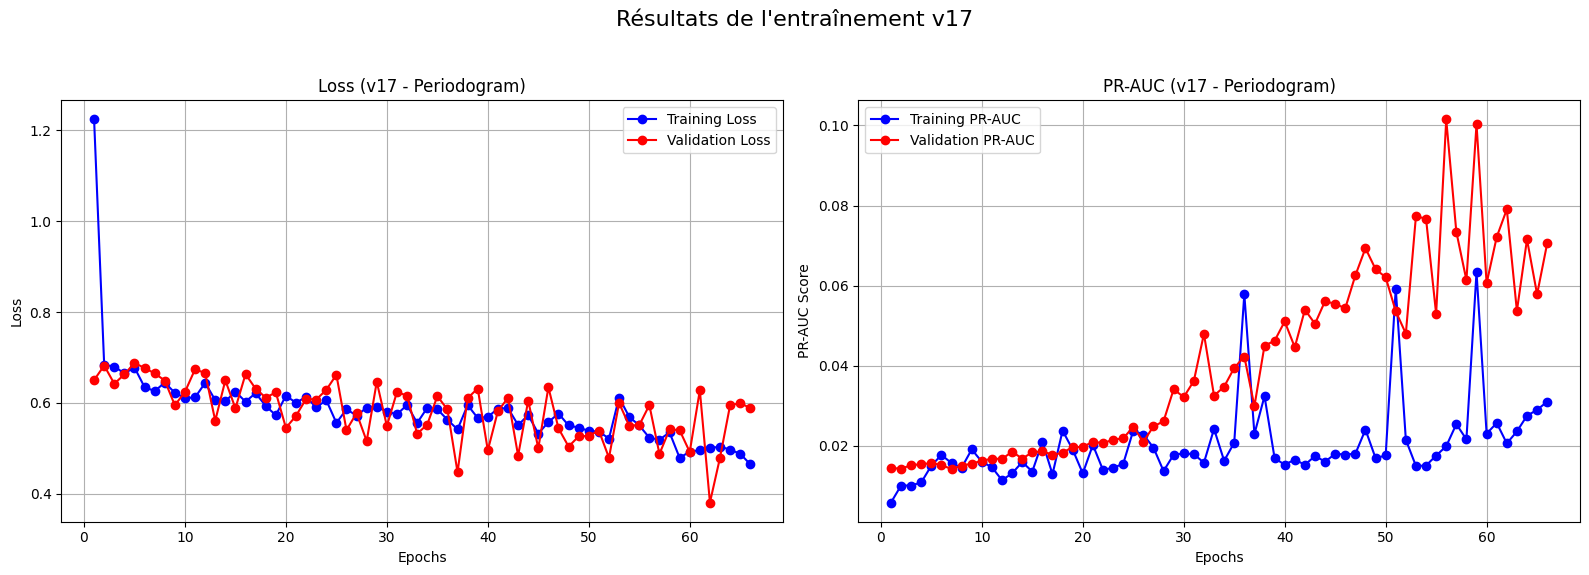

In [11]:
# Cellule 8 : Visualisation des résultats (v17)
# ----------------------------------------------

print("Affichage des graphiques d'entraînement (v17)...")
history_dict = history.history

# Récupérer les métriques
loss = history_dict['loss']
val_loss = history_dict['val_loss']
pr_auc = history_dict['pr_auc']
val_pr_auc = history_dict['val_pr_auc']

# Créer la plage d'époques
actual_epochs = len(loss)
epochs_range = range(1, actual_epochs + 1)

# Créer la figure
plt.figure(figsize=(16, 6))

# Graphique 1 : Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, 'bo-', label='Training Loss')
plt.plot(epochs_range, val_loss, 'ro-', label='Validation Loss')
plt.title('Loss (v17 - Periodogram)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Graphique 2 : PR-AUC
plt.subplot(1, 2, 2)
plt.plot(epochs_range, pr_auc, 'bo-', label='Training PR-AUC')
plt.plot(epochs_range, val_pr_auc, 'ro-', label='Validation PR-AUC')
plt.title('PR-AUC (v17 - Periodogram)')
plt.xlabel('Epochs')
plt.ylabel('PR-AUC Score')
plt.legend()
plt.grid(True)

plt.suptitle("Résultats de l'entraînement v17", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()